# SNAP Analyzing pairwise correlations between firing rates using Pymer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.io import loadmat,savemat
from scipy.signal import deconvolve, savgol_filter



from plotnine import *
# import plotly

# import h5py


from pymer4 import Lmer, Lm


from os import listdir


In [2]:
# Useful functions
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]



In [3]:
fpath = './pwCorr/smoothedCorr_norm/'
files = find_csv_filenames(fpath)

frames = []
for fname in files:
    df = pd.read_csv(fpath+fname)
    frames.append(df)
    
df = pd.concat(frames).drop(labels='typematch',axis=1)

df = df[~np.isnan(df.nc_fmk.values)]
df

,nc_fmk,type1,type2,reg1,reg2,gain1,gain2,subject,session
0,-0.015768,nochange,nochange,ROF,ROF,NaN,NaN,8,1
1,0.103732,nochange,nochange,ROF,ROF,NaN,NaN,8,1
2,0.035276,nochange,nochange,ROF,ROF,NaN,NaN,8,1
3,0.096194,nochange,nochange,ROF,ROF,NaN,NaN,8,1
4,0.036796,nochange,inc,ROF,ROF,NaN,0.325441,8,1
...,...,...,...,...,...,...,...,...,...
736,-0.173628,inc,nochange,LSMA,ROF,0.421593,NaN,4,3
737,-0.082653,inc,nochange,LSMA,ROF,0.421593,NaN,4,3
738,0.516842,nochange,nochange,ROF,ROF,NaN,NaN,4,3
739,0.415992,nochange,nochange,ROF,ROF,NaN,NaN,4,3


In [4]:
df['pwType'] = 'nochange'
df.loc[np.logical_and(df.type1.str.match('inc'),df.type2.str.match('inc')),'pwType'] = 'inc'
df.loc[np.logical_and(df.type1.str.match('dec'),df.type2.str.match('dec')),'pwType'] = 'dec'
df.loc[np.logical_xor(df.type1.str.match('dec'),df.type2.str.match('dec')) & np.logical_xor(df.type1.str.match('inc'),df.type2.str.match('inc')),
      'pwType'] = 'incdec'

# df_pwc = df.drop(np.logical_or(df.type1.str.match('bad'),df.type2.str.match('bad')),axis=0).reset_index()
df_pwc = df.iloc[(~(df.type1.str.match('bad').values)) & (~(df.type2.str.match('bad').values)),:].reset_index()

df_pwc

,index,nc_fmk,type1,type2,reg1,reg2,gain1,gain2,subject,session,pwType
0,0,-0.015768,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
1,1,0.103732,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
2,2,0.035276,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
3,3,0.096194,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
4,4,0.036796,nochange,inc,ROF,ROF,NaN,0.325441,8,1,nochange
...,...,...,...,...,...,...,...,...,...,...,...
19884,736,-0.173628,inc,nochange,LSMA,ROF,0.421593,NaN,4,3,nochange
19885,737,-0.082653,inc,nochange,LSMA,ROF,0.421593,NaN,4,3,nochange
19886,738,0.516842,nochange,nochange,ROF,ROF,NaN,NaN,4,3,nochange
19887,739,0.415992,nochange,nochange,ROF,ROF,NaN,NaN,4,3,nochange


In [5]:
print(df_pwc.pwType.value_counts())

nochange    18334
dec           893
incdec        549
inc           113
Name: pwType, dtype: int64


In [6]:
df.head(50)

,nc_fmk,type1,type2,reg1,reg2,gain1,gain2,subject,session,pwType
0,-0.015768,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
1,0.103732,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
2,0.035276,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
3,0.096194,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
4,0.036796,nochange,inc,ROF,ROF,NaN,0.325441,8,1,nochange
5,0.183120,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
6,-0.010342,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
7,-0.048686,nochange,dec,ROF,ROF,NaN,0.343450,8,1,nochange
8,0.009858,nochange,nochange,ROF,RAC,NaN,NaN,8,1,nochange
9,0.070509,nochange,bad,ROF,RAC,NaN,NaN,8,1,nochange


# Plot the average data- maybe scatter??

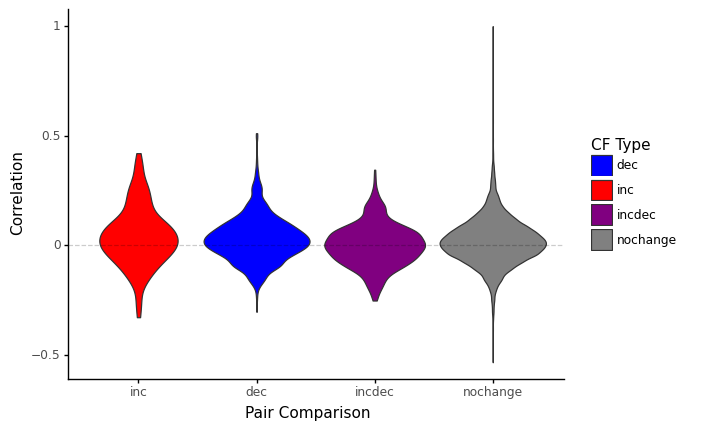

<ggplot: (458417508)>

In [266]:
p=(ggplot(df_pwc,aes(x='pwType',y='nc_fmk',fill='pwType')) +

#    geom_line(aes(y='eeg_base'),color='green') +
  geom_violin()+
   

 scale_x_discrete(name='Pair Comparison',limits = ['inc','dec','incdec','nochange']) +
 scale_y_continuous(name = 'Correlation') +
    scale_fill_manual(name = 'CF Type',values=['blue','red','purple','gray'])+

#    scale_y_continuous(name='EEG Voltage (mV; green); Pupil Size (AU; black)',limits=(-5,5),breaks=np.arange(-7.5,5.1,2.5)) +
#  labs(title='Anticipatory EEG and Pupil Dilations') +
 theme_classic() +
#    scale_
#    geom_vline(xintercept=0,linetype='--',color='black',alpha=0.2) 
   geom_hline(yintercept=0,linetype='--',color='black',alpha=0.2) 
)

# p.save(savepath+'pupil_gavg.eps')
p

# Frequentist Statistical test using LME model

In [7]:
model = Lmer('nc_fmk ~ pwType + (1|subject)',data=df_pwc)
print(model.fit(factors={'pwType':['nochange','inc','dec','incdec']}))

Formula: nc_fmk~pwType+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 19889	 Groups: {'subject': 12.0}

Log-likelihood: 16744.261 	 AIC: -33488.522

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.001  0.030
Residual               0.011  0.104

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE         DF  T-stat  P-val  Sig
(Intercept)     0.022   0.005    0.040  0.009     11.190   2.549  0.027    *
pwType1         0.030   0.010    0.049  0.010  19875.403   3.025  0.002   **
pwType2         0.017   0.010    0.024  0.004  19884.563   4.689  0.000  ***
pwType3        -0.012  -0.021   -0.003  0.005  19878.620  -2.651  0.008   **


In [8]:
# For plotting, have a 0 intercept so each pwtype has its intercept & confidence interval estimated separately


model = Lmer('nc_fmk ~ 0 + pwType + (1|subject)',data=df_pwc)
print(model.fit(factors={'pwType':['nochange','inc','dec','incdec']}))

Formula: nc_fmk~0+pwType+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 19889	 Groups: {'subject': 12.0}

Log-likelihood: 16744.261 	 AIC: -33488.522

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.001  0.030
Residual               0.011  0.104

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
pwTypenochange     0.022   0.005    0.040  0.009  11.190   2.549  0.027    *
pwTypeinc          0.052   0.026    0.078  0.013  55.826   3.966  0.000  ***
pwTypedec          0.039   0.021    0.058  0.009  14.813   4.169  0.001  ***
pwTypeincdec       0.010  -0.009    0.030  0.010  17.447   1.061  0.303     


In [9]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
pwTypenochange,0.022424,0.005182,0.039666,0.008797,11.190115,2.549053,0.026726,*
pwTypeinc,0.052158,0.026381,0.077935,0.013152,55.826409,3.965872,0.000210,***
pwTypedec,0.039346,0.020850,0.057842,0.009437,14.812561,4.169365,0.000843,***
pwTypeincdec,0.010428,-0.008841,0.029697,0.009831,17.446556,1.060717,0.303283,


In [10]:
df_temp = model.coefs.copy()
# df_temp['Estimate'] = df_temp['Estimate']+model.coefs['Estimate'][0]
# df_temp['2.5_ci'] = df_temp['2.5_ci']+model.coefs['Estimate'][0]
# df_temp['97.5_ci'] = df_temp['97.5_ci']+model.coefs['Estimate'][0]
# df_temp.iloc[0,0] = model.coefs['Estimate'][0]
# df_temp.iloc[0,1] = model.coefs['2.5_ci'][0]
# df_temp.iloc[0,2] = model.coefs['97.5_ci'][0]



df_temp

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
pwTypenochange,0.022424,0.005182,0.039666,0.008797,11.190115,2.549053,0.026726,*
pwTypeinc,0.052158,0.026381,0.077935,0.013152,55.826409,3.965872,0.000210,***
pwTypedec,0.039346,0.020850,0.057842,0.009437,14.812561,4.169365,0.000843,***
pwTypeincdec,0.010428,-0.008841,0.029697,0.009831,17.446556,1.060717,0.303283,


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_x_discrete could not recognise parameter `values`
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/model_preds/pwcorr_norm_bar.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/model_preds/pwcorr_norm_bar.svg


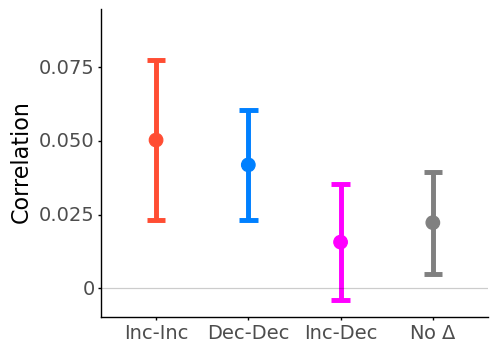

<ggplot: (457171830)>

In [27]:
df_temp['pwType'] = ['No Change','Inc-Inc','Dec-Dec','Inc-Dec']
# df_temp=df_est
p = (ggplot(df_temp,aes(x='pwType',y='Estimate',color='pwType')) +
     
#      geom_col(color='white') +
#      geom_violin(aes(y='nc_fmk'),data=df_pwc)+
     geom_point(size=5) +
     geom_errorbar(aes(ymin='2.5_ci',ymax='97.5_ci'),size=2,width=0.2)+
     scale_y_continuous(name='Correlation')+
     coord_cartesian(ylim=(-0.005,0.09))+
     scale_x_discrete(limits = ['Inc-Inc','Dec-Dec','Inc-Dec','No Change',],
                      values=['No Change','Inc-Inc','Dec-Dec','Inc-Dec'],
                     labels = ['Inc-Inc','Dec-Dec','Inc-Dec','No $\Delta$',])+
     scale_fill_manual(name = 'CF Type',values=['blue','purple','red','gray'])+
     scale_color_manual(values = ['#%02x%02x%02x' % (0, 128, 255),'magenta','#%02x%02x%02x' % (255, 77, 51),'gray'])+
     theme_classic()+ 
    geom_hline(yintercept=0,color='black',alpha=0.2) +

     theme(legend_position = "none",
          
           axis_text = element_text(size=14),
           axis_ticks_length = 2,
           axis_title_x = element_blank(),
           axis_title_y = element_text(size=16),
          figure_size=(5,4))
    )
p.save('figures/model_preds/pwcorr_norm_bar.png')
p.save('figures/model_preds/pwcorr_norm_bar.svg')

p

In [38]:
p=(ggplot(df_pwc,aes(x='pwType',y='nc_fmk',fill='pwType')) +

#    geom_line(aes(y='eeg_base'),color='green') +
  geom_violin()+
   geom_errorbar(aes(y='Estimate',ymin='2.5_ci',ymax='97.5_ci'),data=df_temp,size=2,width=0.2)+
   geom_point(aes(y='Estimate'),size=5) +

 scale_x_discrete(name='Pair Comparison',limits = ['inc','dec','incdec','nochange']) +
 scale_y_continuous(name = 'Correlation') +
    scale_fill_manual(name = 'CF Type',values=['blue','red','purple','gray'])+

#    scale_y_continuous(name='EEG Voltage (mV; green); Pupil Size (AU; black)',limits=(-5,5),breaks=np.arange(-7.5,5.1,2.5)) +
#  labs(title='Anticipatory EEG and Pupil Dilations') +
 theme_classic() +
#    scale_
#    geom_vline(xintercept=0,linetype='--',color='black',alpha=0.2) 
   geom_hline(yintercept=0,linetype='--',color='black',alpha=0.2) 
)

# p.save(savepath+'pupil_gavg.eps')
p

PlotnineError: "Could not evaluate the 'y' mapping: 'Estimate' (original error: name 'Estimate' is not defined)"

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_ydensity : Removed 98 rows containing non-finite values.


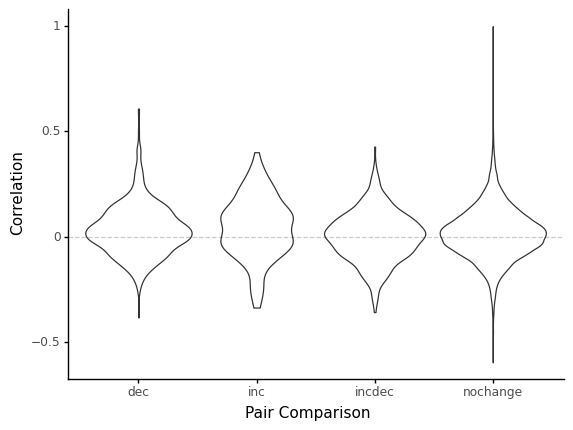

<ggplot: (453855302)>

In [26]:
p=(ggplot(df_pwc,aes(x='pwType',y='nc_fmk')) +

#    geom_line(aes(y='eeg_base'),color='green') +
  geom_violin()+

 scale_x_discrete(name='Pair Comparison') +
 scale_y_continuous(name = 'Correlation') +
#    scale_y_continuous(name='EEG Voltage (mV; green); Pupil Size (AU; black)',limits=(-5,5),breaks=np.arange(-7.5,5.1,2.5)) +
#  labs(title='Anticipatory EEG and Pupil Dilations') +
 theme_classic() +
#    geom_vline(xintercept=0,linetype='--',color='black',alpha=0.2) 
   geom_hline(yintercept=0,linetype='--',color='black',alpha=0.2) 
)

# p.save(savepath+'pupil_gavg.eps')
p

In [308]:
df_temp = df_est[df_est.orType.isin(['notOR'])]
# df_temp=df_est
p = (ggplot(df_temp,aes(x='timebin',y='Estimate',color = 'precueType')) +
     geom_point(position=position_dodge(0.2),size=3) + 
     geom_line(aes(group='precueType',color='precueType'),size=1.2)+
#      geom_col(position=position_dodge(),color='black') +
     geom_errorbar(aes(ymin='CI95low',ymax='CI95high'),width=0.2,position=position_dodge(0.2))+
     scale_y_continuous(name='Reaction Time (ms)')+
     coord_cartesian(ylim=(500,760))+
     scale_x_discrete(name='Time between pre-cue and go-cue (ms)',
                      limits=('200','300','400','500','700-1000','1000+'))+
     scale_color_manual(name='Condition',
                        labels=['Free','Instructed'],
                        values=['purple','red'])+
     theme_classic()
    )

NameError: name 'df_est' is not defined

## Splitting based on gain of fitted sigmoid & sub-selecting to MFC neurons, if there are enough

In [16]:
df_pwc

,index,nc_fmk,type1,type2,reg1,reg2,gain1,gain2,subject,session,pwType
0,0,-0.015768,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
1,1,0.103732,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
2,2,0.035276,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
3,3,0.096194,nochange,nochange,ROF,ROF,NaN,NaN,8,1,nochange
4,4,0.036796,nochange,inc,ROF,ROF,NaN,0.325441,8,1,nochange
...,...,...,...,...,...,...,...,...,...,...,...
19884,736,-0.173628,inc,nochange,LSMA,ROF,0.421593,NaN,4,3,nochange
19885,737,-0.082653,inc,nochange,LSMA,ROF,0.421593,NaN,4,3,nochange
19886,738,0.516842,nochange,nochange,ROF,ROF,NaN,NaN,4,3,nochange
19887,739,0.415992,nochange,nochange,ROF,ROF,NaN,NaN,4,3,nochange


In [30]:
df_temp = df_pwc.copy()
gain_ix = (df_pwc.gain1.values >= 0.4) & (df_pwc.gain2.values >= 0.4)
mfcRegions = ['LAC','LACCr','LACr' ,'LDAC' ,'LRAC' ,'LSMA' ,'LpSMA','RAC'  ,'RACCr','RACr' ,'RRAC' ,'RSMA' ,'RpSMA']
mfc_ix = (df_pwc.reg1.isin(mfcRegions)) & (df_pwc.reg2.isin(mfcRegions))
df_temp.loc[(gain_ix) & (mfc_ix),'pwType'] = 'nochange'

model = Lmer('nc_fmk ~ 0 + pwType + (1|subject)',data=df_temp)
print(model.fit(factors={'pwType':['inc','incdec','dec','nochange']}))

Formula: nc_fmk~0+pwType+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 19889	 Groups: {'subject': 12.0}

Log-likelihood: 16740.677 	 AIC: -33481.353

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.001  0.030
Residual               0.011  0.104

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
pwTypeinc          0.048   0.022    0.074  0.013  58.902   3.613  0.001  ***
pwTypeincdec       0.011  -0.008    0.030  0.010  17.693   1.102  0.285     
pwTypedec          0.038   0.020    0.057  0.009  14.952   4.033  0.001   **
pwTypenochange     0.023   0.005    0.040  0.009  11.189   2.563  0.026    *


In [31]:
df_temp['pwType'].value_counts()

nochange    18384
dec           865
incdec        532
inc           108
Name: pwType, dtype: int64

In [32]:
marginal_estimates, comparisons = model.post_hoc(
    marginal_vars="pwType"#, grouping_vars=["precueType"]
)

# "Cell" means of the ANOVA
print(marginal_estimates)

P-values adjusted by tukey method for family of 6 estimates
     pwType  Estimate  2.5_ci  97.5_ci     SE   DF
0       inc     0.048   0.022    0.074  0.013  inf
1    incdec     0.011  -0.008    0.030  0.010  inf
2       dec     0.038   0.020    0.057  0.009  inf
3  nochange     0.023   0.005    0.040  0.009  inf


In [33]:
print(comparisons)

            Contrast  Estimate  2.5_ci  97.5_ci     SE   DF  Z-stat  P-val  \
0       inc - incdec     0.037   0.009    0.065  0.011  inf   3.389  0.004   
1          inc - dec     0.010  -0.017    0.037  0.011  inf   0.939  0.784   
2     inc - nochange     0.026  -0.000    0.051  0.010  inf   2.545  0.053   
3       incdec - dec    -0.027  -0.042   -0.012  0.006  inf  -4.742  0.000   
4  incdec - nochange    -0.012  -0.023    0.000  0.005  inf  -2.537  0.054   
5     dec - nochange     0.016   0.006    0.025  0.004  inf   4.254  0.000   

   Sig  
0   **  
1       
2    .  
3  ***  
4    .  
5  ***  


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/model_preds/pwcorr_norm_bar_slowramponly_mfc.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/model_preds/pwcorr_norm_bar_slowramponly_mfc.svg


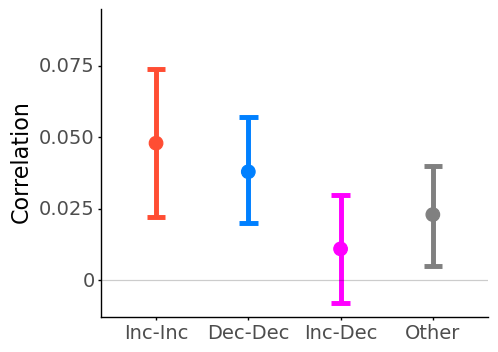

<ggplot: (453345425)>

In [34]:
df_temp = marginal_estimates.copy()

df_temp['pwType'] = ['Inc-Inc','Inc-Dec','Dec-Dec','Other',]

# df_temp = df_temp[df_temp.pwType != 'No Change']
# df_temp=df_est
p = (ggplot(df_temp,aes(x='pwType',y='Estimate',color='pwType')) +
     
#      geom_col(color='white') +
#      geom_violin(aes(y='nc_fmk'),data=df_pwc)+
     geom_point(size=5) +
     geom_errorbar(aes(ymin='2.5_ci',ymax='97.5_ci'),size=2,width=0.2)+
     scale_y_continuous(name='Correlation')+
     coord_cartesian(ylim=(-0.008,0.09))+
     scale_x_discrete(limits = ['Inc-Inc','Dec-Dec','Inc-Dec','Other',],
                     labels = ['Inc-Inc','Dec-Dec','Inc-Dec','Other',])+
     scale_fill_manual(name = 'CF Type',values=['blue','purple','red','gray'])+
     scale_color_manual(values = ['#%02x%02x%02x' % (0, 128, 255),'magenta','#%02x%02x%02x' % (255, 77, 51),'gray'])+
     theme_classic()+ 
    geom_hline(yintercept=0,color='black',alpha=0.2) +

     theme(legend_position = "none",
          
           axis_text = element_text(size=14),
           axis_ticks_length = 2,
           axis_title_x = element_blank(),
           axis_title_y = element_text(size=16),
          figure_size=(5,4))
    )
p.save('figures/model_preds/pwcorr_norm_bar_slowramponly_mfc.png')
p.save('figures/model_preds/pwcorr_norm_bar_slowramponly_mfc.svg')

p

Formula: nc_fmk~0+pwType+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 3362	 Groups: {'subject': 11.0}

Log-likelihood: 3036.377 	 AIC: -6072.754

Random effects:

                 Name   Var    Std
subject   (Intercept)  0.00  0.006
Residual               0.01  0.098

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
pwTypenochange     0.012   0.006    0.018  0.003     9.467   4.164  0.002   **
pwTypeinc          0.047   0.021    0.073  0.013  1731.417   3.542  0.000  ***
pwTypedec          0.030   0.021    0.039  0.005    56.466   6.627  0.000  ***
pwTypeincdec       0.007  -0.004    0.018  0.006   137.586   1.235  0.219     


# Bayesian Model Fitting

In [77]:
import arviz as az
import bambi as bmb

ModuleNotFoundError: No module named 'arviz'

In [50]:
model = bmb.Model('nc_fmk ~ 0 + pwType + (1|subject)',data=df_pwc)

In [51]:
# Fit the model using 1000 on each of 4 chains
results = model.fit(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pwType, 1|subject_sigma, 1|subject_offset, nc_fmk_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 265 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6749, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.


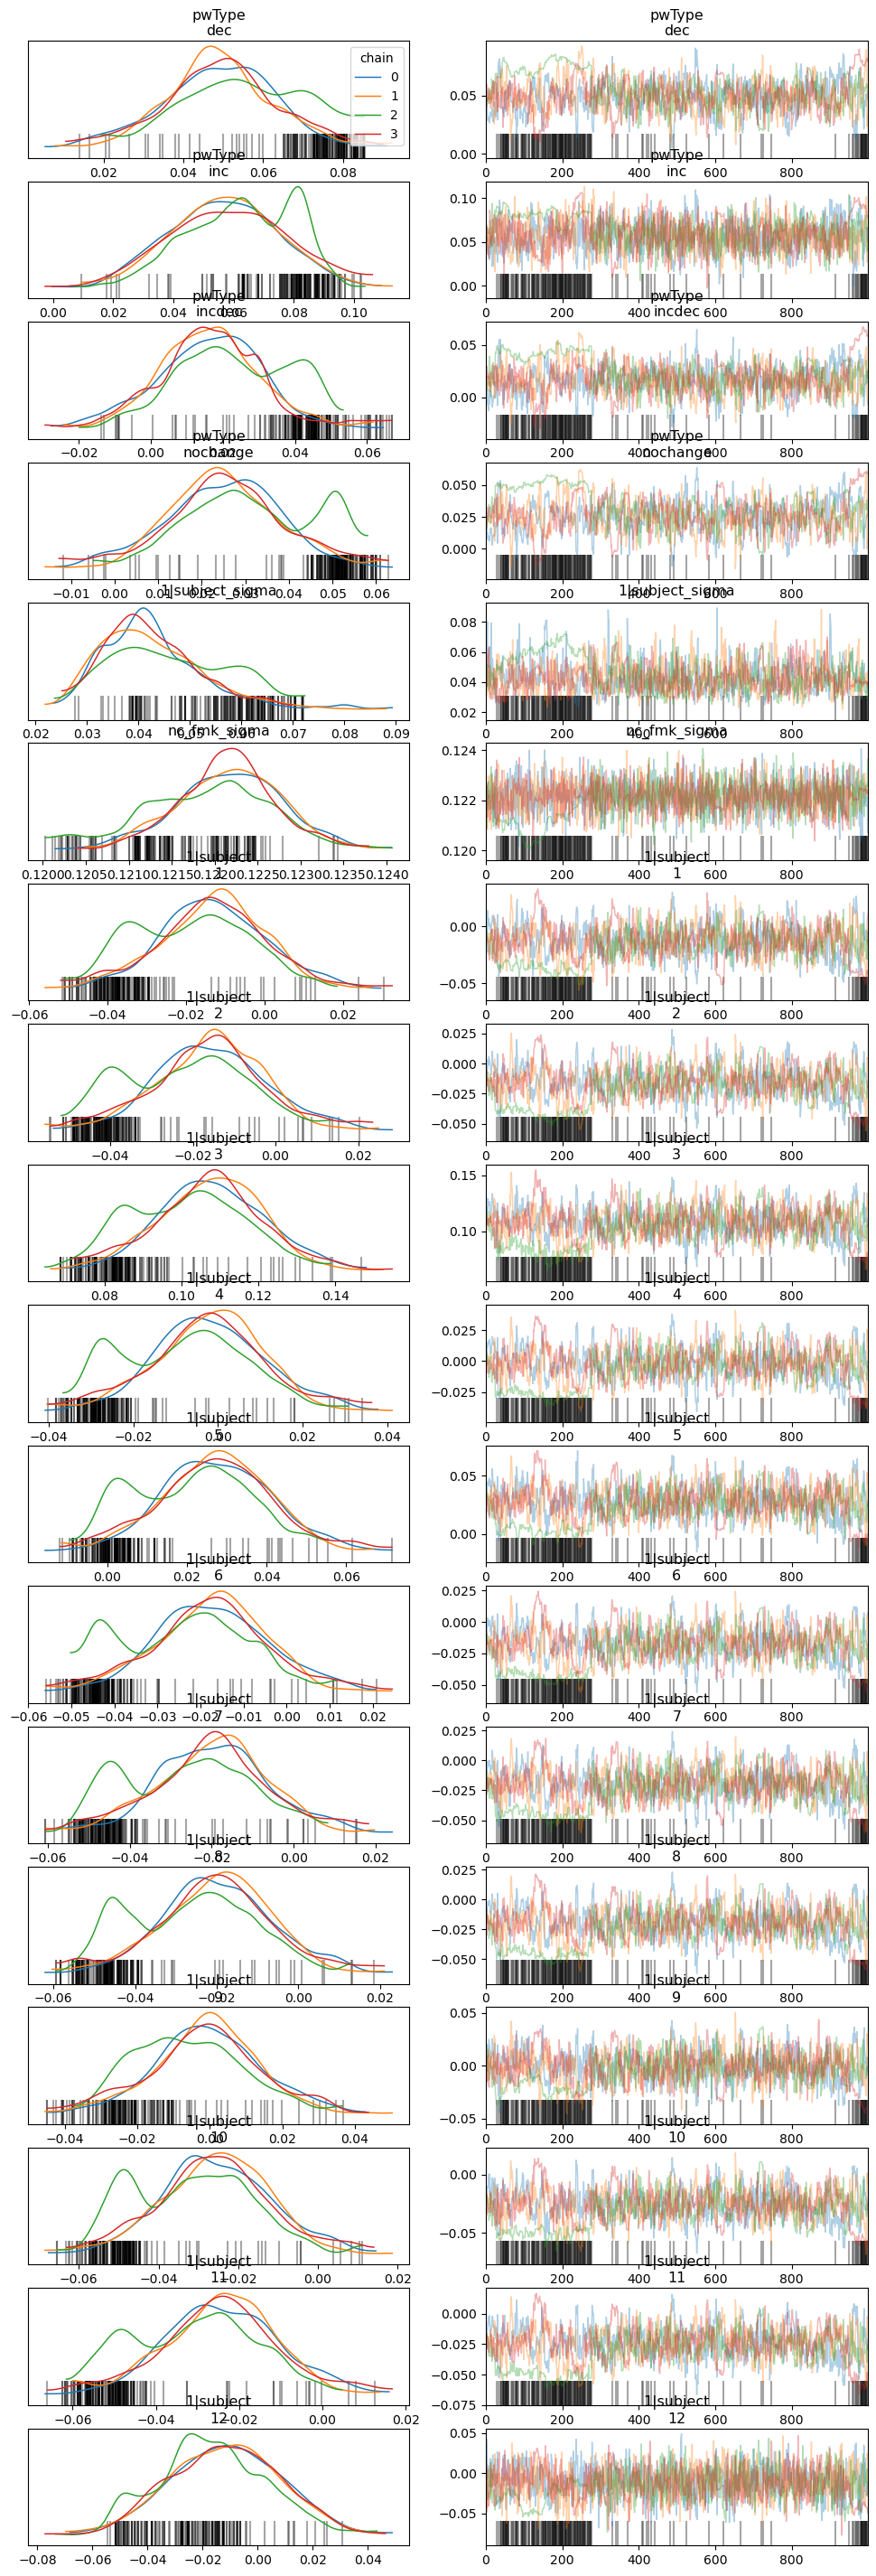

In [53]:
# Use ArviZ to plot the results
az.plot_trace(results,legend=True,compact=False);

In [54]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pwType[dec],0.051,0.015,0.025,0.081,0.002,0.002,59.0,91.0,1.06
pwType[inc],0.059,0.018,0.025,0.092,0.001,0.001,212.0,358.0,1.03
pwType[incdec],0.018,0.015,-0.009,0.047,0.002,0.002,56.0,83.0,1.06
pwType[nochange],0.027,0.014,0.003,0.055,0.002,0.002,54.0,71.0,1.06
1|subject_sigma,0.044,0.010,0.028,0.064,0.001,0.001,118.0,153.0,1.04
nc_fmk_sigma,0.122,0.001,0.121,0.123,0.000,0.000,81.0,99.0,1.04
1|subject[1],-0.015,0.015,-0.044,0.010,0.002,0.001,73.0,134.0,1.05
1|subject[2],-0.017,0.014,-0.047,0.007,0.002,0.002,56.0,67.0,1.06
1|subject[3],0.106,0.015,0.078,0.132,0.002,0.001,58.0,91.0,1.06
1|subject[4],-0.004,0.014,-0.032,0.021,0.002,0.001,55.0,72.0,1.06


In [ ]:
df_temp = az.summary(results)
df_temp['Estimate'] = df_temp['Estimate']+model.coefs['Estimate'][0]
df_temp['2.5_ci'] = df_temp['2.5_ci']+model.coefs['Estimate'][0]
df_temp['97.5_ci'] = df_temp['97.5_ci']+model.coefs['Estimate'][0]
df_temp.iloc[0,0] = model.coefs['Estimate'][0]
df_temp.iloc[0,1] = model.coefs['2.5_ci'][0]
df_temp.iloc[0,2] = model.coefs['97.5_ci'][0]



df_temp

# Simulated Data

In [334]:
fpath = './pwCorr/flux/smoothedCorr_norm/'
files = find_csv_filenames(fpath)

frames = []
for fname in files:
    df = pd.read_csv(fpath+fname)
    frames.append(df)
    
df = pd.concat(frames).drop(labels='typematch',axis=1).dropna(axis=0)

In [335]:
df['pwType'] = 'nochange'
df.loc[np.logical_and(df.type1.str.match('inc'),df.type2.str.match('inc')),'pwType'] = 'inc'
df.loc[np.logical_and(df.type1.str.match('dec'),df.type2.str.match('dec')),'pwType'] = 'dec'
df.loc[np.logical_xor(df.type1.str.match('dec'),df.type2.str.match('dec')) & np.logical_xor(df.type1.str.match('inc'),df.type2.str.match('inc')),
      'pwType'] = 'incdec'

# df_pwc = df.drop(np.logical_or(df.type1.str.match('bad'),df.type2.str.match('bad')),axis=0).reset_index()
df_pwc = df.iloc[(~(df.type1.str.match('bad').values)) & (~(df.type2.str.match('bad').values)),:].reset_index()

df_pwc

,index,nc_fmk,type1,type2,network,pwType
0,0,0.058022,inc,inc,10,inc
1,1,0.066336,inc,inc,10,inc
2,2,0.364824,inc,inc,10,inc
3,3,0.222908,inc,inc,10,inc
4,4,-0.085428,inc,inc,10,inc
...,...,...,...,...,...,...
985095,51035,-0.004108,dec,nochange,8,nochange
985096,51036,-0.060144,dec,dec,8,dec
985097,51037,-0.108871,nochange,nochange,8,nochange
985098,51038,-0.051257,nochange,dec,8,nochange


In [336]:
df.pwType.value_counts()

nochange    505257
dec         215747
incdec      210132
inc          53964
Name: pwType, dtype: int64

In [337]:
model = Lmer('nc_fmk ~ 0 + pwType + (1|network)',data=df_pwc)
print(model.fit(factors={'pwType':['nochange','inc','dec','incdec']}))

Formula: nc_fmk~0+pwType+(1|network)

Family: gaussian	 Inference: parametric

Number of observations: 985100	 Groups: {'network': 20.0}

Log-likelihood: 655595.350 	 AIC: -1311190.701

Random effects:

                 Name    Var    Std
network   (Intercept)  0.000  0.002
Residual               0.015  0.124

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE      DF   T-stat  P-val  Sig
pwTypenochange     0.003   0.002    0.004  0.000  21.846    6.056    0.0  ***
pwTypeinc          0.277   0.276    0.278  0.001  90.908  392.871    0.0  ***
pwTypedec          0.059   0.058    0.060  0.001  30.451  109.004    0.0  ***
pwTypeincdec      -0.115  -0.116   -0.114  0.001  30.190 -215.320    0.0  ***


In [338]:
marginal_estimates, comparisons = model.post_hoc(
    marginal_vars="pwType"#, grouping_vars=["precueType"]
)

# "Cell" means of the ANOVA
print(marginal_estimates)

P-values adjusted by tukey method for family of 6 estimates
     pwType  Estimate  2.5_ci  97.5_ci     SE   DF
0  nochange     0.003   0.002    0.004  0.000  inf
1       inc     0.277   0.276    0.278  0.001  inf
2       dec     0.059   0.058    0.060  0.001  inf
3    incdec    -0.115  -0.116   -0.114  0.001  inf


In [339]:
print(comparisons)

            Contrast  Estimate  2.5_ci  97.5_ci     SE   DF   Z-stat  P-val  \
0     nochange - inc    -0.274  -0.276   -0.273  0.001  inf -482.044    0.0   
1     nochange - dec    -0.056  -0.056   -0.055  0.000  inf -159.517    0.0   
2  nochange - incdec     0.118   0.117    0.119  0.000  inf  346.342    0.0   
3          inc - dec     0.219   0.217    0.220  0.001  inf  363.067    0.0   
4       inc - incdec     0.392   0.391    0.394  0.001  inf  652.726    0.0   
5       dec - incdec     0.174   0.173    0.175  0.000  inf  454.938    0.0   

   Sig  
0  ***  
1  ***  
2  ***  
3  ***  
4  ***  
5  ***  


In [19]:
# For plotting, have a 0 intercept so each pwtype has its intercept & confidence interval estimated separately
model = Lmer('nc_fmk ~ 0 + pwType + (1|network)',data=df_pwc)
print(model.fit(factors={'pwType':['nochange','inc','dec','incdec']}))

Formula: nc_fmk~0+pwType+(1|network)

Family: gaussian	 Inference: parametric

Number of observations: 985100	 Groups: {'network': 20.0}

Log-likelihood: 655595.350 	 AIC: -1311190.701

Random effects:

                 Name    Var    Std
network   (Intercept)  0.000  0.002
Residual               0.015  0.124

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE      DF   T-stat  P-val  Sig
pwTypenochange     0.003   0.002    0.004  0.000  21.846    6.056    0.0  ***
pwTypeinc          0.277   0.276    0.278  0.001  90.908  392.871    0.0  ***
pwTypedec          0.059   0.058    0.060  0.001  30.451  109.004    0.0  ***
pwTypeincdec      -0.115  -0.116   -0.114  0.001  30.190 -215.320    0.0  ***


In [20]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
pwTypenochange,0.002992,0.002024,0.003961,0.000494,21.846193,6.056256,4.403470e-06,***
pwTypeinc,0.277096,0.275714,0.278479,0.000705,90.908204,392.870706,1.252891e-148,***
pwTypedec,0.058562,0.057509,0.059615,0.000537,30.451019,109.004416,4.858663e-41,***
pwTypeincdec,-0.115346,-0.116396,-0.114296,0.000536,30.189598,-215.320047,1.141689e-49,***


In [21]:
df_temp = model.coefs.copy()
# df_temp['Estimate'] = df_temp['Estimate']+model.coefs['Estimate'][0]
# df_temp['2.5_ci'] = df_temp['2.5_ci']+model.coefs['Estimate'][0]
# df_temp['97.5_ci'] = df_temp['97.5_ci']+model.coefs['Estimate'][0]
# df_temp.iloc[0,0] = model.coefs['Estimate'][0]
# df_temp.iloc[0,1] = model.coefs['2.5_ci'][0]
# df_temp.iloc[0,2] = model.coefs['97.5_ci'][0]



df_temp

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
pwTypenochange,0.002992,0.002024,0.003961,0.000494,21.846193,6.056256,4.403470e-06,***
pwTypeinc,0.277096,0.275714,0.278479,0.000705,90.908204,392.870706,1.252891e-148,***
pwTypedec,0.058562,0.057509,0.059615,0.000537,30.451019,109.004416,4.858663e-41,***
pwTypeincdec,-0.115346,-0.116396,-0.114296,0.000536,30.189598,-215.320047,1.141689e-49,***


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_x_discrete could not recognise parameter `values`
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/model_preds/pwcorr_norm_bar_flux.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/model_preds/pwcorr_norm_bar_flux.svg


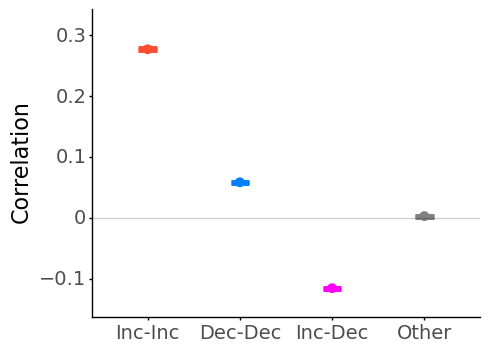

<ggplot: (458045591)>

In [25]:
df_temp['pwType'] = ['No Change','Inc-Inc','Dec-Dec','Inc-Dec']
# df_temp=df_est
p = (ggplot(df_temp,aes(x='pwType',y='Estimate',color='pwType')) +
     
#      geom_col(color='white') +
#      geom_violin(aes(y='nc_fmk'),data=df_pwc)+
     geom_point(size=3) +
     geom_errorbar(aes(ymin='2.5_ci',ymax='97.5_ci'),size=2,width=0.2)+
     scale_y_continuous(name='Correlation')+
     coord_cartesian(ylim=(-0.14,0.32))+
     scale_x_discrete(limits = ['Inc-Inc','Dec-Dec','Inc-Dec','No Change',],
                      values=['No Change','Inc-Inc','Dec-Dec','Inc-Dec'],
                     labels = ['Inc-Inc','Dec-Dec','Inc-Dec','Other',])+
     scale_fill_manual(name = 'CF Type',values=['blue','purple','red','gray'])+
     scale_color_manual(values = ['#%02x%02x%02x' % (0, 128, 255),'magenta','#%02x%02x%02x' % (255, 77, 51),'gray'])+
     theme_classic()+ 
    geom_hline(yintercept=0,color='black',alpha=0.2) +

     theme(legend_position = "none",
          
           axis_text = element_text(size=14),
           axis_ticks_length = 2,
           axis_title_x = element_blank(),
           axis_title_y = element_text(size=16),
          figure_size=(5,4))
    )
p.save('figures/model_preds/pwcorr_norm_bar_flux.png')
p.save('figures/model_preds/pwcorr_norm_bar_flux.svg')

p